In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV

In [5]:
import lightgbm as lgb
import xgboost as xgb

### 데이터 불러오기

In [2]:
train_dt = pd.read_csv('./train.csv')
test_dt = pd.read_csv('./test.csv')

In [3]:
train_dt.shape, test_dt.shape

((4250, 20), (750, 20))

### y값 0,1 데이터 형식으로 매핑

In [12]:
bn_dict = {'no':0, 'yes':1}
train_dt['churn'] = train_dt['churn'].map(bn_dict)
train_dt['churn']

In [30]:
train_dt

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,0
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,0
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,0
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,0


### 결측치 확인

In [6]:
train_dt.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

### 데이터 요약

In [9]:
train_dt.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
account_length,4250.0,100.236235,39.698401,1.0,73.0000,100.00,127.0000,243.00
number_vmail_messages,4250.0,7.631765,13.439882,0.0,0.0000,0.00,16.0000,52.00
total_day_minutes,4250.0,180.259600,54.012373,0.0,143.3250,180.45,216.2000,351.50
total_day_calls,4250.0,99.907294,19.850817,0.0,87.0000,100.00,113.0000,165.00
total_day_charge,4250.0,30.644682,9.182096,0.0,24.3650,30.68,36.7500,59.76
total_eve_minutes,4250.0,200.173906,50.249518,0.0,165.9250,200.70,233.7750,359.30
total_eve_calls,4250.0,100.176471,19.908591,0.0,87.0000,100.00,114.0000,170.00
total_eve_charge,4250.0,17.015012,4.271212,0.0,14.1025,17.06,19.8675,30.54
total_night_minutes,4250.0,200.527882,50.353548,0.0,167.2250,200.45,234.7000,395.00
total_night_calls,4250.0,99.839529,20.093220,0.0,86.0000,100.00,113.0000,175.00


In [10]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

### pop 함수로 특정 열 추출 가능

In [12]:
y = train_dt.pop('churn')

0       no
1       no
2       no
3       no
4       no
        ..
4245    no
4246    no
4247    no
4248    no
4249    no
Name: churn, Length: 4250, dtype: object

### Train, Test 합치기

In [15]:
train_dt['Is_train'] = True
test_dt['Is_train'] = False
total_dt = pd.concat([train_dt, test_dt])
print(train_dt.shape, test_dt.shape, total_dt.shape)

(4250, 20) (750, 21) (5000, 21)


In [16]:
total_dt.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Is_train,id
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,True,NaN
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,True,NaN
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,True,NaN
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,True,NaN
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,...,29.62,212.6,118,9.57,7.5,7,2.03,3,True,NaN


### pd.option에서 디스플레이할 행렬 조절 가능

In [26]:
pd.options.display.max_columns = 21
pd.options.display.max_rows = 500
pd.get_option('max_rows')

### 'yes', 'no' binary 데이터 -> 0,1 형식으로 변환

총 3가지 방식이 있음   
1) np.where로 조건 걸기 (단점은, 2개 이상의 class에 대해 처리 못함)   
2) pd.map({딕셔너리}) - key, value 형태로 맵핑 (series, 즉 한 열에만 가능)   
3) pd.replace({딕셔너리}) - 2번과 유사하지만 dataframe 상대로 가능 -> df 내 여러 행을 딕셔너리 형태로 수정가능

In [29]:
total_dt['international_plan'] = np.where(total_dt['international_plan'].str.contains('yes'),1,0)
total_dt['voice_mail_plan'] = np.where(total_dt['voice_mail_plan'].str.contains('yes'),1,0)

In [33]:
total_dt = total_dt.replace({'international_plan':{1:'yes',0:'no'}})

In [38]:
total_dt = total_dt.replace({'international_plan':{'yes':1,'no':0},
                             'voice_mail_plan':{'yes':1,'no':0}})

In [40]:
total_dt['international_plan'].head(5)

0    0
1    0
2    1
3    1
4    0
Name: international_plan, dtype: int64

In [39]:
total_dt['voice_mail_plan'].head(5)

0    1
1    0
2    0
3    0
4    1
Name: voice_mail_plan, dtype: int64

### state, code 값 dummy 변수로 변환

In [42]:
# columns명을 지정해주면 더미변수 앞에 prefix로 붙음
total_dt = pd.get_dummies(total_dt, columns = ['state','area_code'])

In [54]:
train_dt = total_dt[total_dt['Is_train']==True]
test_dt = total_dt[total_dt['Is_train']==False]

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(train_dt,y,test_size=0.3)

In [75]:
len(train_dt.columns), len(X_train.columns)

(73, 72)

In [78]:
X_train.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'id', 'state_AK',
       'state_AL', 'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DC', 'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA',
       'state_ID', 'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA',
       'state_MA', 'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH',
       'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK',
       'state_OR', 'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN',
       'state_TX', 's

In [57]:
X_test.shape

(1063, 73)

# EDA 및 그래프 시각화

# Validation Curve 실습

### X, y 데이터로 분류

In [34]:
X = train_dt[['total_day_calls','total_day_minutes','total_day_charge','total_eve_charge','total_night_minutes','total_night_calls',
  'total_night_charge','total_intl_minutes','total_intl_calls', 'total_intl_charge','number_customer_service_calls']]
y = train_dt['churn']

### Parameter range 정하기

In [38]:
param_range = np.logspace(-6, -1, 10)

In [39]:
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

### 시간 재면서 validation_curve 생성

In [47]:
%%time
## cv는 cross-validation, scoring="accuracy"기반임
train_scores, test_scores = \
    validation_curve(SVC(), X, y,
                     param_name="gamma", param_range=param_range,
                     cv=10, scoring="accuracy", n_jobs=1)

Wall time: 3min 4s


In [49]:
indices= np.arange(y.shape[0])

In [51]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

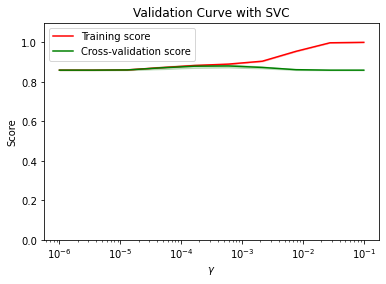

In [54]:
mpl.rcParams["font.family"] = 'DejaVu Sans'
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean,
             label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with SVC")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.show()